In [5]:
import pandas as pd
import rrcf
import numpy as np
import sys
#sys.path.append('..')
#sys.path.insert(0, '')
from helpers import forest_to_dict
import seaborn as sns
import json

# Carga de datos

En primer lugar, se cargan los ficheros de tráfico de la sede que se desee analizar. Estos ficheros deben haber sido previamente procesados ():

In [11]:
traffic_data = pd.read_csv('../data/bbva_ven_data/BBVA-VEN-CCS-MP-U-320594.csv')
traffic_data.head()

,SC_ROUTER,DE_INTERFACE,NU_SPEED,NU_TRAFFIC_INPUT,NU_TRAFFIC_OUTPUT,DT_MEASURE_DATETIME,SC_INTERFACE_TYPE,DE_CUSTOMER_NAME,SD_ADMINISTRATIVE_NUMBER,WEEKEND
0,BBVA-VEN-CCS-MP-U-320594,GigabitEthernet0/1,122.88,1.401181,41.975232,2018-03-01 00:00:00,WAN,BBVA,320594,False
1,BBVA-VEN-CCS-MP-U-320594,GigabitEthernet0/1,122.88,1.418632,42.995528,2018-03-01 00:05:00,WAN,BBVA,320594,False
2,BBVA-VEN-CCS-MP-U-320594,GigabitEthernet0/1,122.88,1.427320,43.089572,2018-03-01 00:10:00,WAN,BBVA,320594,False
3,BBVA-VEN-CCS-MP-U-320594,GigabitEthernet0/1,122.88,1.430821,42.490928,2018-03-01 00:15:00,WAN,BBVA,320594,False
4,BBVA-VEN-CCS-MP-U-320594,GigabitEthernet0/1,122.88,1.438027,43.630344,2018-03-01 00:20:00,WAN,BBVA,320594,False


A continuación se cargan los datos de incidencias correspondientes a la sede, también previamente procesados()

In [3]:
incidents_filtered = pd.read_csv('../data/bbva_ven_data/incidenciasBBVA-Venezuela.csv')
incidents_filtered.head() 

,TICKET_ID,SERVICE_TYPE,SUBMIT_DATE,LAST_MODIFICATION_DATE,ASSIGNED_SUPPORT_COMPANY,REPORTED_DATE,REPORTED_SOURCE_ID,OPERATING_COMPANY_NAME,OPERATING_LE,CONTACT_COMPANY_NAME,...,OPERATIONAL_CATEGORIZATION_TIER_2,OPERATIONAL_CATEGORIZATION_TIER_3,CLOSURE_CATEGORIZATION_TIER_1,CLOSURE_CATEGORIZATION_TIER_2,CLOSURE_CATEGORIZATION_TIER_3,VENDOR_GROUP,INF2_HPD_OUTAGE_DURATION,CI_COUNTRY,ADMIN_NUMBER,INSTANCEID
0,INC000000581948,User Service Restoration,2017-03-15 22:45:03,2019-07-18 19:50:08,Telefonica,2017-03-15 22:44:47,2000.0,Telefónica Venezuela (TELCEL),Banco Bilbao Vizcaya Argentaria (BBVA),NaN,...,MWAN - Performance,Slowness and/or Delays,CUSTOMER,Bad request,NaN,Telefónica Venezuela (TELCEL),2.0,Venezuela,20110621-SITEMPLS-0000320594,IDHAA5V0A57OPAOMVNZIBDAVKB2CW8
1,INC000000581960,User Service Restoration,2017-03-15 23:28:23,2019-07-18 19:51:05,Telefónica Venezuela (TELCEL),2017-03-15 23:28:23,15001.0,Telefónica Venezuela (TELCEL),TELCEL C.A. (TEL MOV VENEZUELA),NaN,...,MWAN - Performance,Slowness and/or Delays,CUSTOMER,Bad request,NaN,Telefónica Venezuela (TELCEL),2.0,Venezuela,20110621-SITEMPLS-0000320594,AGHAA5V0A57OPAOMVQ9JBEZWFY27IL
2,INC000000582963,User Service Restoration,2017-03-18 01:13:21,2019-07-18 19:50:08,Telefonica,2017-03-18 01:06:56,1000.0,Telefónica Venezuela (TELCEL),Banco Bilbao Vizcaya Argentaria (BBVA),NaN,...,MWAN - Failure,Service Reports,CUSTOMER,Bad request,NaN,Telefónica Venezuela (TELCEL),1.0,Venezuela,20110621-SITEMPLS-0000320594,AGHAA5V0A57OPAOMZKQHEDMK9IF6NO
3,INC000000582968,User Service Restoration,2017-03-18 01:29:38,2019-07-18 19:51:05,Telefónica Venezuela (TELCEL),2017-03-18 01:29:38,15001.0,Telefónica Venezuela (TELCEL),TELCEL C.A. (TEL MOV VENEZUELA),NaN,...,MWAN - Failure,Service Reports,CUSTOMER,Bad request,NaN,Telefónica Venezuela (TELCEL),1.0,NaN,20110621-SITEMPLS-0000320594,AGHAA5V0A57OPAOMZL72EEH87HFRC5
4,INC000000603180,User Service Restoration,2017-04-25 14:50:50,2019-07-18 19:49:29,Telefonica,2017-04-25 14:49:56,1000.0,Telefónica Venezuela (TELCEL),Banco Bilbao Vizcaya Argentaria (BBVA),NaN,...,MWAN - Performance,Slowness and/or Delays,NaN,NaN,NaN,NaN,0.0,Venezuela,20110621-SITEMPLS-0000320594,AGHAA5V0A57OPAOOYZWOA1J0YVFFPL


# Fase de entrenamiento

Se seleccionan los meses de entrenamiento del modelo. Debido a que para que el funcionamiento del algoritmo sea el deseado, los datos de entrenamiento deben ser lo más "normales" posibles. Entendiéndose "normal" como libres de anomalías, en la medida de lo posible. Por ello se eliminan los 0 presentes en la serie:

In [15]:
traffic_series = pd.Series(traffic_data.NU_TRAFFIC_OUTPUT.values, index = traffic_data.DT_MEASURE_DATETIME.values)
train_data = traffic_series['2019-01-01 00:00:00':'2019-03-31 23:55:00']
train_data = train_data[train_data != 0] 

In [16]:
num_trees = 50
tree_size = 512
train_index = train_data.index.values
forest = []
while len(forest) < num_trees:
    samples = np.random.choice(train_index, size = (num_trees, tree_size), replace = True)
    trees = [rrcf.RCTree(np.vstack(train_data.loc[sample].values), index_labels = sample) for sample in samples]
    forest.extend(trees) 

# Fase de scoring

Se seleccionan los datos que se desee *scorear*. Se simula un *scoreo* de los datos en *streaming* a través de un bucle *for*:

In [35]:
test_data = traffic_series['2019-04-01 00:00:00':'2019-12-31 23:55:00']
codisp_no_shingle = pd.Series(0, index = test_data.index.values)

for next_index,next_point in test_data.items():
    for tree in forest:
        tree.insert_point(next_point, index=next_index)
        codisp_no_shingle[next_index] += tree.codisp(next_index)
        tree.forget_point(next_index)
avg_codisp_no_shingle = codisp_no_shingle/num_trees 

El resultado devuelto es un vector de *anomaly scores*. Este vector es convertido a *dataframe* para poder ser guardado y utilizado posteriormente:

In [36]:
avg_codisp_no_shingle.name = 'Anomaly score'
avg_codisp_no_shingle = avg_codisp_no_shingle.to_frame()
avg_codisp_no_shingle.reset_index(inplace=True)
avg_codisp_no_shingle.rename(columns={'index':'Date'}, inplace=True)
avg_codisp_no_shingle.describe()

,Anomaly score
count,79200.000000
mean,13.147790
std,25.978384
min,2.340000
25%,3.960000
50%,4.780000
75%,8.960000
max,206.240000


In [37]:
avg_codisp_no_shingle.shape

(79200, 2)

In [38]:
# Se puede guardar para su posterior uso
# avg_codisp_no_shingle.to_csv('../data/bbva_ven_data/anomaly_score_abr_dic', index = False)

# Selección de threshold estadístico

In [7]:
avg_codisp_no_shingle = pd.read_csv("../data/bbva_ven_data/anomaly_score_abr_dic.csv")

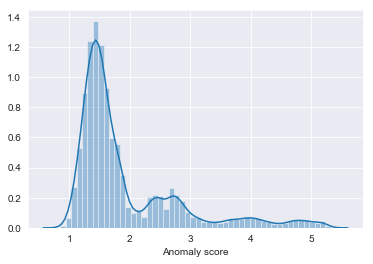

In [8]:
sns.set_style("darkgrid")
ax = sns.distplot(np.log(avg_codisp_no_shingle['Anomaly score']), label = "Anomaly Score")
ax

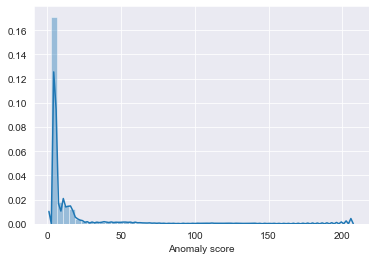

In [40]:
sns.set_style("darkgrid")
ax = sns.distplot(avg_codisp_no_shingle['Anomaly score'], label = "Anomaly Score")
ax

In [10]:
stat_threshold = avg_codisp_no_shingle["Anomaly score"].quantile(.99)
stat_threshold

150.9605999999997

In [12]:
avg_codisp_no_shingle['Alarm'] = 0.0
avg_codisp_no_shingle.loc[(avg_codisp_no_shingle['Anomaly score'] > stat_threshold), 'Alarm'] = 1.0
alarms = avg_codisp_no_shingle.loc[(avg_codisp_no_shingle['Alarm'] == 1.0)]
alarms = alarms.merge(traffic_data, how = 'inner', left_on = 'Date', right_on = 'DT_MEASURE_DATETIME')
alarms = alarms[["Date", "Anomaly score", "NU_TRAFFIC_INPUT", "NU_TRAFFIC_OUTPUT"]]
alarms.head()

,Date,Anomaly score,NU_TRAFFIC_INPUT,NU_TRAFFIC_OUTPUT
0,2019-04-01 19:50:00,172.36,0.0,0.0
1,2019-04-09 19:10:00,181.12,0.0,0.0
2,2019-04-16 21:00:00,174.82,0.0,0.0
3,2019-04-23 19:20:00,173.78,0.0,0.0
4,2019-04-28 01:55:00,172.98,0.0,0.0


In [13]:
alarms.shape

(792, 4)

In [48]:
#alarms.to_csv("../data/bbva_ven_data/alarms_statistical_threshold.csv", index = False)

In [18]:
# Creamos un archivo json donde guardamos los thresholds y el forest utilizado
forest_dict = forest_to_dict(forest) 
forest_dict["statistic_threshold"] = stat_threshold
with open('../data/bbva_ven_data/320594_GigabitEthernet01_output.json', 'w') as output_file:
    json.dump(forest_dict, output_file)